# Peg Keeper Death Spiral Simulation

Here we create a Peg Keeper object for each existing Peg Keeper, and hook it on to an existing StableSwap pool using Curvesim. Then we simulate agents acting against these Peg Keepers and pools based on some input market prices.

The specific input we are studying in this notebook is if the market price for one of the four peg keeper tokens depegs.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from curvesim.pool import get_sim_pool
import numpy as np
from src.modules.pegkeeperv1 import PegKeeperV1
from src.modules.aggregator import AggregateStablePrice
from src.agents.arbitrageur import Arbitrageur
import time
import matplotlib.pyplot as plt

In [3]:
USDC_POOL = "0x4DEcE678ceceb27446b35C672dC7d61F30bAD69E"
USDT_POOL = "0x390f3595bca2df7d23783dfd126427cceb997bf4"
USDP_POOL = "0xca978a0528116dda3cba9acd3e68bc6191ca53d0"
TUSD_POOL = "0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0"

# Aggregator Params
SIGMA = 0.001

# PegKeeper Params
CALLER_SHARE = 0.2
CEILING = 25_000_000 # For USDC/USDT

In [4]:
pools = [get_sim_pool(address, balanced=False) for address in [USDC_POOL, USDT_POOL]]
# pools = {address:get_sim_pool(address, balanced=False) for address in [USDC_POOL, USDT_POOL, USDP_POOL, TUSD_POOL]}
arbitrageur = Arbitrageur(0, True)
agg = AggregateStablePrice(pools, SIGMA)
pks = [PegKeeperV1(pool, agg, CALLER_SHARE, CEILING) for pool in pools]

Goal: Implement a function that determines the profit from moving pool price to some target price, then use scipy's optimize to find the most profitable trade. This should account for external market slippage.

Would be cool to then incorporate this into `curvesim` as a `LiquidityLimitedArbitrage`! However, this would likely result in a surprising amount of work, so let's keep things simple for now.

## Showing that profit maximization is working

0.9979002099790021


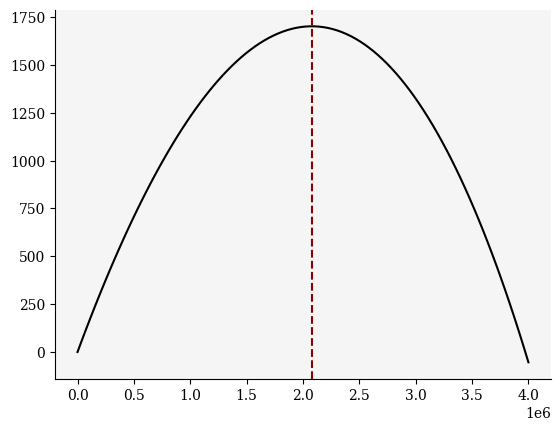

In [5]:
I = 1
PRECISION = 1e18

p_usdc = 0.998
p_usdt = 1.0001
p = p_usdc/p_usdt
prices = [p_usdc, p_usdt] # arbitrary USDC/USDT, USDT/USDC prices
print(p)
amts = np.linspace(0, 4_000_000, 100)
profits = [Arbitrageur.profit(amt_in, pools[0], pools[1], p) for amt_in in amts]
trade = Arbitrageur.search(pools, prices)

plt.plot(amts, profits, color='black')
plt.axvline(trade.size/PRECISION, color='darkred', linestyle='--')

In [6]:
profit = arbitrageur.arbitrage(pools, prices)

Arbitrage trade with profit 1702.


In [7]:
pools_cp = [get_sim_pool(address, balanced=False) for address in [USDC_POOL, USDT_POOL]]
print('Original price from Curve pools:', pools_cp[0].price(0, 1) / pools_cp[1].price(0, 1))
print('Market price:', p)
print('Final price from Curve pools:', pools[0].price(0, 1) / pools[1].price(0, 1))

Original price from Curve pools: 0.9996976214054155
Market price: 0.9979002099790021
Final price from Curve pools: 0.9980999289977566


Notice that the arbitrage process correctly brings the price from the crvUSD pools closer to the prevailing market price for those tokens! This indicates that the logic for our arbitrage is correct. Of course, due to fees and price impact on Curve pools, the prices aren't perfectly equilibrated.

In [8]:
from datetime import datetime
from src.sim.prices import get_prices_df
from curvesim.network.coingecko import coin_ids_from_addresses_sync

USDC = "0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48"
USDT = "0xdac17f958d2ee523a2206206994597c13d831ec7"

coins = [USDC, USDT]
coins = coin_ids_from_addresses_sync(coins, "mainnet")

start = datetime(2023, 3, 5).timestamp()
end = datetime(2023, 3, 15).timestamp()

df = get_prices_df(coins, start, end)

[DEBUG][23:21:37][urllib3.connectionpool]-96732: Starting new HTTPS connection (1): api.coingecko.com:443
[DEBUG][23:21:37][urllib3.connectionpool]-96732: https://api.coingecko.com:443 "GET /api/v3/coins/usd-coin/market_chart/range?vs_currency=usd&from=1677992400.0&to=1678852800.0 HTTP/1.1" 200 None
[DEBUG][23:21:37][urllib3.connectionpool]-96732: Starting new HTTPS connection (1): api.coingecko.com:443
[DEBUG][23:21:37][urllib3.connectionpool]-96732: https://api.coingecko.com:443 "GET /api/v3/coins/tether/market_chart/range?vs_currency=usd&from=1677992400.0&to=1678852800.0 HTTP/1.1" 200 None


In [9]:
# FIXME clearly PK estimate_caller_profit is not working
# since it gives positive pnl but update() then gives 0 pnl

for i, row in df.iterrows():

    # First arbitraguers call the PK.update() function
    # FIXME what is the right order here?
    update_pnl, update_count = arbitrageur.update(pks, row['timestamp'])

    # Then arbitrageurs will arbitrage the pools
    # FIXME rn assuming only two pools
    prices = row['usd-coin'], row['tether']
    arbitrage_pnl, arbitrage_count = arbitrageur.arbitrage(pools, prices)

    # Track metrics
    df.loc[i, 'update_pnl'] = update_pnl
    df.loc[i, 'update_count'] = update_count
    df.loc[i, 'arbitrage_pnl'] = arbitrage_pnl
    df.loc[i, 'arbitrage_count'] = arbitrage_count
    df.loc[i, 'usdc_crvUSD'] = pools[0].price(0, 1)
    df.loc[i, 'usdt_crvUSD'] = pools[1].price(0, 1)

Updating crvUSD/USDC Peg Keeper with pnl 0.
Updating crvUSD/USDT Peg Keeper with pnl 0.
Arbitrage trade with profit 1943.
Updating crvUSD/USDC Peg Keeper with pnl 0.
Updating crvUSD/USDT Peg Keeper with pnl 0.
Updating crvUSD/USDC Peg Keeper with pnl 0.
Updating crvUSD/USDT Peg Keeper with pnl 0.
Arbitrage trade with profit 2.
Updating crvUSD/USDC Peg Keeper with pnl 0.
Updating crvUSD/USDT Peg Keeper with pnl 0.
Updating crvUSD/USDC Peg Keeper with pnl 0.
Updating crvUSD/USDT Peg Keeper with pnl 0.
Arbitrage trade with profit 12.
Updating crvUSD/USDC Peg Keeper with pnl 0.
Updating crvUSD/USDT Peg Keeper with pnl 0.
Updating crvUSD/USDC Peg Keeper with pnl 0.
Updating crvUSD/USDT Peg Keeper with pnl 0.
Updating crvUSD/USDC Peg Keeper with pnl 0.
Updating crvUSD/USDT Peg Keeper with pnl 0.
Arbitrage trade with profit 23.
Updating crvUSD/USDC Peg Keeper with pnl 0.
Updating crvUSD/USDT Peg Keeper with pnl 0.
Arbitrage trade with profit 2.
Updating crvUSD/USDC Peg Keeper with pnl 0.
Upda

In [12]:
df['arbitrage_pnl'].sum()

343214.7629285611

<Axes: xlabel='datetime'>

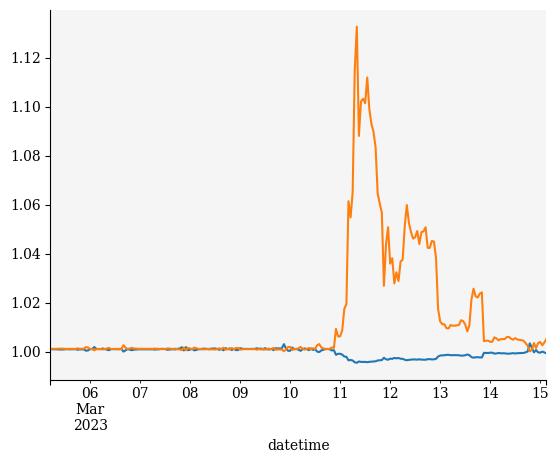

In [17]:
df['usdc_crvUSD'].plot()
df['usdt_crvUSD'].plot()

In [ ]:
"""
TODO
1. Update clearly not working (not being called, and estimate_caller_profit() is broken by the PROFIT_THRESHOLD).
2. Why does USDT price shoot up by 12% instead of USDC price fall by 8%?
3. Why are arbitrage profits so low? 350k for this weekend seems absurdly little.
"""

In [11]:
### Simulating Death Spiral

# TODO Create classes for metrics like in curvesim?
# TODO Determine metrics for PK depeg (i.e., minted crvUSD, burned crvUSD, net unbacked crvUSD, PK profits, liquidity weighted price)
# Definitely want to track p_agg throughout the run.
# Currently assuming LPs don't pull liquidity

# Generate correlated prices using Cholesky decomposition
# TODO incorporate mean reversion and jumps 
# TODO how to force depeg?

# Generate reasonable liquidity curve f(x, sigma)
# Should slippage also be a function of volatility of other token prices?

# Get USDC/USDT prices during SVB collapse

# Instantiate the curve pools + PKs + agg

# Loop through prices:

    # Update oracle prices/aggregator <- this doesn't actually require us to do anything

    # Update external liquidity curve <- don't actually have to do anything here

    # Check arbitrage <- 

    # Check update <- 

    # Update metrics <- 
    # Turn this into a class?